# Data Scholar :: Code Along :: Twitter Sentiment Analysis (Covid-19)

### Import Libraries

In [1]:
pip install plotly-express

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd 
import numpy as np 

import matplotlib.pyplot as plt 
import re
import string

import nltk
from nltk.tokenize import sent_tokenize
from nltk.corpus import words
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.util import *
nltk.download('stopwords')
nltk.download('vader_lexicon')


from collections import Counter

from matplotlib import ticker
import seaborn as sns
import plotly.express as px


sns.set(style="darkgrid")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


### Import Dataset

In [9]:
df = pd.read_csv('covid19_tweets.csv')
df.head()

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet
0,ᏉᎥ☻լꂅϮ,astroworld,wednesday addams as a disney princess keepin i...,2017-05-26 05:46:42,624,950,18775,False,2020-07-25 12:27:21,If I smelled the scent of hand sanitizers toda...,NaN,Twitter for iPhone,False
1,Tom Basile 🇺🇸,"New York, NY","Husband, Father, Columnist & Commentator. Auth...",2009-04-16 20:06:23,2253,1677,24,True,2020-07-25 12:27:17,Hey @Yankees @YankeesPR and @MLB - wouldn't it...,NaN,Twitter for Android,False
2,Time4fisticuffs,"Pewee Valley, KY",#Christian #Catholic #Conservative #Reagan #Re...,2009-02-28 18:57:41,9275,9525,7254,False,2020-07-25 12:27:14,@diane3443 @wdunlap @realDonaldTrump Trump nev...,['COVID19'],Twitter for Android,False
3,ethel mertz,Stuck in the Middle,#Browns #Indians #ClevelandProud #[]_[] #Cavs ...,2019-03-07 01:45:06,197,987,1488,False,2020-07-25 12:27:10,@brookbanktv The one gift #COVID19 has give me...,['COVID19'],Twitter for iPhone,False
4,DIPR-J&K,Jammu and Kashmir,🖊️Official Twitter handle of Department of Inf...,2017-02-12 06:45:15,101009,168,101,False,2020-07-25 12:27:08,25 July : Media Bulletin on Novel #CoronaVirus...,"['CoronaVirusUpdates', 'COVID19']",Twitter for Android,False


In [10]:
df.shape

(179108, 13)

In [11]:
req_cols = ['user_name', 'date', 'text']
df = df[req_cols]
df.head()

,user_name,date,text
0,ᏉᎥ☻լꂅϮ,2020-07-25 12:27:21,If I smelled the scent of hand sanitizers toda...
1,Tom Basile 🇺🇸,2020-07-25 12:27:17,Hey @Yankees @YankeesPR and @MLB - wouldn't it...
2,Time4fisticuffs,2020-07-25 12:27:14,@diane3443 @wdunlap @realDonaldTrump Trump nev...
3,ethel mertz,2020-07-25 12:27:10,@brookbanktv The one gift #COVID19 has give me...
4,DIPR-J&K,2020-07-25 12:27:08,25 July : Media Bulletin on Novel #CoronaVirus...


### Processing Content

In [12]:
df.user_name = df.user_name.astype('category')
df.user_name = df.user_name.cat.codes

df.date = pd.to_datetime(df.date).dt.date
df.head()

,user_name,date,text
0,89755,2020-07-25,If I smelled the scent of hand sanitizers toda...
1,76403,2020-07-25,Hey @Yankees @YankeesPR and @MLB - wouldn't it...
2,76147,2020-07-25,@diane3443 @wdunlap @realDonaldTrump Trump nev...
3,84572,2020-07-25,@brookbanktv The one gift #COVID19 has give me...
4,18398,2020-07-25,25 July : Media Bulletin on Novel #CoronaVirus...


In [13]:
texts = df['text']
texts

0         If I smelled the scent of hand sanitizers toda...
1         Hey @Yankees @YankeesPR and @MLB - wouldn't it...
2         @diane3443 @wdunlap @realDonaldTrump Trump nev...
3         @brookbanktv The one gift #COVID19 has give me...
4         25 July : Media Bulletin on Novel #CoronaVirus...
                                ...                        
179103    Thanks @IamOhmai for nominating me for the @WH...
179104    2020! The year of insanity! Lol! #COVID19 http...
179105    @CTVNews A powerful painting by Juan Lucena. I...
179106    More than 1,200 students test positive for #CO...
179107    I stop when I see a Stop\n\n@SABCNews\n@Izinda...
Name: text, Length: 179108, dtype: object

In [14]:
remove_url = lambda x: re.sub('https\S+', '', str(x))
texts_lr = texts.apply(remove_url)
texts_lr

0         If I smelled the scent of hand sanitizers toda...
1         Hey @Yankees @YankeesPR and @MLB - wouldn't it...
2         @diane3443 @wdunlap @realDonaldTrump Trump nev...
3         @brookbanktv The one gift #COVID19 has give me...
4         25 July : Media Bulletin on Novel #CoronaVirus...
                                ...                        
179103    Thanks @IamOhmai for nominating me for the @WH...
179104           2020! The year of insanity! Lol! #COVID19 
179105    @CTVNews A powerful painting by Juan Lucena. I...
179106    More than 1,200 students test positive for #CO...
179107    I stop when I see a Stop\n\n@SABCNews\n@Izinda...
Name: text, Length: 179108, dtype: object

In [15]:
to_lower = lambda x: x.lower()
texts_lr_lc = texts_lr.apply(to_lower)
texts_lr_lc

0         if i smelled the scent of hand sanitizers toda...
1         hey @yankees @yankeespr and @mlb - wouldn't it...
2         @diane3443 @wdunlap @realdonaldtrump trump nev...
3         @brookbanktv the one gift #covid19 has give me...
4         25 july : media bulletin on novel #coronavirus...
                                ...                        
179103    thanks @iamohmai for nominating me for the @wh...
179104           2020! the year of insanity! lol! #covid19 
179105    @ctvnews a powerful painting by juan lucena. i...
179106    more than 1,200 students test positive for #co...
179107    i stop when i see a stop\n\n@sabcnews\n@izinda...
Name: text, Length: 179108, dtype: object

In [16]:
remove_punc = lambda x: x.translate(str.maketrans('', '', string.punctuation))
texts_lr_lc_np = texts_lr_lc.apply(remove_punc)
texts_lr_lc_np

0         if i smelled the scent of hand sanitizers toda...
1         hey yankees yankeespr and mlb  wouldnt it have...
2         diane3443 wdunlap realdonaldtrump trump never ...
3         brookbanktv the one gift covid19 has give me i...
4         25 july  media bulletin on novel coronavirusup...
                                ...                        
179103    thanks iamohmai for nominating me for the who ...
179104               2020 the year of insanity lol covid19 
179105    ctvnews a powerful painting by juan lucena its...
179106    more than 1200 students test positive for covi...
179107    i stop when i see a stop\n\nsabcnews\nizindaba...
Name: text, Length: 179108, dtype: object

In [17]:
more_words = ['covid','#coronavirus', '#coronavirusoutbreak', '#coronavirusPandemic', '#covid19', '#covid_19', '#epitwitter', '#ihavecorona', 'amp', 'coronavirus', 'covid19']
stop_words = set(stopwords.words('english'))
stop_words.update(more_words)

remove_words = lambda x: ' '.join([word for word in x.split() if word not in stop_words])
texts_lr_lc_np_ns = texts_lr_lc_np.apply(remove_words)
texts_lr_lc_np_ns

0         smelled scent hand sanitizers today someone pa...
1         hey yankees yankeespr mlb wouldnt made sense p...
2         diane3443 wdunlap realdonaldtrump trump never ...
3         brookbanktv one gift give appreciation simple ...
4         25 july media bulletin novel coronavirusupdate...
                                ...                        
179103    thanks iamohmai nominating wearamask challenge...
179104                               2020 year insanity lol
179105    ctvnews powerful painting juan lucena tribute ...
179106    1200 students test positive major university a...
179107    stop see stop sabcnews izindabanews24 dailysun...
Name: text, Length: 179108, dtype: object

In [19]:
word_list = [word for line in texts_lr_lc_np_ns for word in line.split()]
word_list

['smelled',
 'scent',
 'hand',
 'sanitizers',
 'today',
 'someone',
 'past',
 'would',
 'think',
 'intoxicated',
 'that…',
 'hey',
 'yankees',
 'yankeespr',
 'mlb',
 'wouldnt',
 'made',
 'sense',
 'players',
 'pay',
 'respects',
 'a…',
 'diane3443',
 'wdunlap',
 'realdonaldtrump',
 'trump',
 'never',
 'claimed',
 'hoax',
 'claim',
 'effort',
 'to…',
 'brookbanktv',
 'one',
 'gift',
 'give',
 'appreciation',
 'simple',
 'things',
 'always',
 'around',
 'me…',
 '25',
 'july',
 'media',
 'bulletin',
 'novel',
 'coronavirusupdates',
 'kansalrohit69',
 'drsyedsehrish',
 'airnewsalerts',
 'ani…',
 'deaths',
 'continue',
 'rise',
 'almost',
 'bad',
 'ever',
 'politicians',
 'businesses',
 'want…',
 'change',
 'work',
 'general',
 'recruiting',
 'specifically',
 'via',
 'proactivetalent',
 'recruiting…',
 'wear',
 'face',
 'coverings',
 'shopping',
 'includes',
 'visit',
 'local',
 'community',
 'pharmacy…',
 'praying',
 'good',
 'health',
 'recovery',
 'chouhanshivraj',
 'covidpositive',
 'po

In [23]:
word_counts = Counter(word_list).most_common(50)
word_counts

words_df = pd.DataFrame(word_counts)
words_df.columns = ['word', 'frequency']

px.bar(words_df, x='word', y='frequency', title = 'Most common words')

In [24]:
df.text = texts_lr_lc_np_ns
df.head()

,user_name,date,text
0,89755,2020-07-25,smelled scent hand sanitizers today someone pa...
1,76403,2020-07-25,hey yankees yankeespr mlb wouldnt made sense p...
2,76147,2020-07-25,diane3443 wdunlap realdonaldtrump trump never ...
3,84572,2020-07-25,brookbanktv one gift give appreciation simple ...
4,18398,2020-07-25,25 july media bulletin novel coronavirusupdate...


### Sentiment Analysis

In [25]:
sid = SentimentIntensityAnalyzer()
ps = lambda x: sid.polarity_scores(x)
sentiment_score = df.text.apply(ps)
sentiment_score

0         {'neg': 0.0, 'neu': 0.758, 'pos': 0.242, 'comp...
1         {'neg': 0.11, 'neu': 0.709, 'pos': 0.181, 'com...
2         {'neg': 0.0, 'neu': 0.832, 'pos': 0.168, 'comp...
3         {'neg': 0.0, 'neu': 0.563, 'pos': 0.437, 'comp...
4         {'neg': 0.0, 'neu': 0.796, 'pos': 0.204, 'comp...
                                ...                        
179103    {'neg': 0.0, 'neu': 0.588, 'pos': 0.412, 'comp...
179104    {'neg': 0.435, 'neu': 0.235, 'pos': 0.329, 'co...
179105    {'neg': 0.25, 'neu': 0.556, 'pos': 0.194, 'com...
179106    {'neg': 0.0, 'neu': 0.66, 'pos': 0.34, 'compou...
179107    {'neg': 0.355, 'neu': 0.645, 'pos': 0.0, 'comp...
Name: text, Length: 179108, dtype: object

In [26]:
sentiment_df = pd.DataFrame(data = list(sentiment_score))
sentiment_df.head()

,neg,neu,pos,compound
0,0.00,0.758,0.242,0.4939
1,0.11,0.709,0.181,0.2263
2,0.00,0.832,0.168,0.2057
3,0.00,0.563,0.437,0.7351
4,0.00,0.796,0.204,0.3182


In [27]:
labelise = lambda x: 'neutral' if x == 0 else('positive' if x > 0 else 'negative')
sentiment_df['label'] = sentiment_df.compound.apply(labelise)
sentiment_df.head()

,neg,neu,pos,compound,label
0,0.00,0.758,0.242,0.4939,positive
1,0.11,0.709,0.181,0.2263,positive
2,0.00,0.832,0.168,0.2057,positive
3,0.00,0.563,0.437,0.7351,positive
4,0.00,0.796,0.204,0.3182,positive


In [28]:
data = df.join(sentiment_df.label)
data

,user_name,date,text,label
0,89755,2020-07-25,smelled scent hand sanitizers today someone pa...,positive
1,76403,2020-07-25,hey yankees yankeespr mlb wouldnt made sense p...,positive
2,76147,2020-07-25,diane3443 wdunlap realdonaldtrump trump never ...,positive
3,84572,2020-07-25,brookbanktv one gift give appreciation simple ...,positive
4,18398,2020-07-25,25 july media bulletin novel coronavirusupdate...,positive
...,...,...,...,...
179103,2024,2020-08-29,thanks iamohmai nominating wearamask challenge...,positive
179104,36471,2020-08-29,2020 year insanity lol,negative
179105,8688,2020-08-29,ctvnews powerful painting juan lucena tribute ...,negative
179106,28623,2020-08-29,1200 students test positive major university a...,positive


### Plots & Word Clouds

In [29]:
counts_df = data.label.value_counts().reset_index()
counts_df

,index,label
0,positive,70048
1,neutral,62520
2,negative,46540


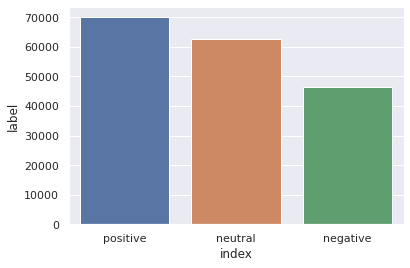

In [30]:
sns.barplot(x='index', y='label', data=counts_df)

In [32]:
data_agg = data[['user_name', 'date', 'label']].groupby(['date', 'label']).count().reset_index()
data_agg
data_agg.columns = ['date', 'label', 'counts']

In [33]:
px.line(data_agg, x='date', y='counts', color='label', title='Daily Tweet Sentiment')

In [34]:
from wordcloud import WordCloud

In [35]:
mask_pos = data['label'] == 'positive'
positive_texts = data.loc[mask_pos, ['text']]

mask_neu = data['label'] == 'neutral'
neutral_texts = data.loc[mask_neu, ['text']]

mask_neg = data['label'] == 'negative'
negative_texts = data.loc[mask_neg, ['text']]

In [36]:
pos_text = ' '.join(text for text in positive_texts.text)

In [38]:
wordcloud = WordCloud(width=800,
                      height=400,
                      max_words=100,
                      max_font_size=50,
                      background_color='white').generate(pos_text)

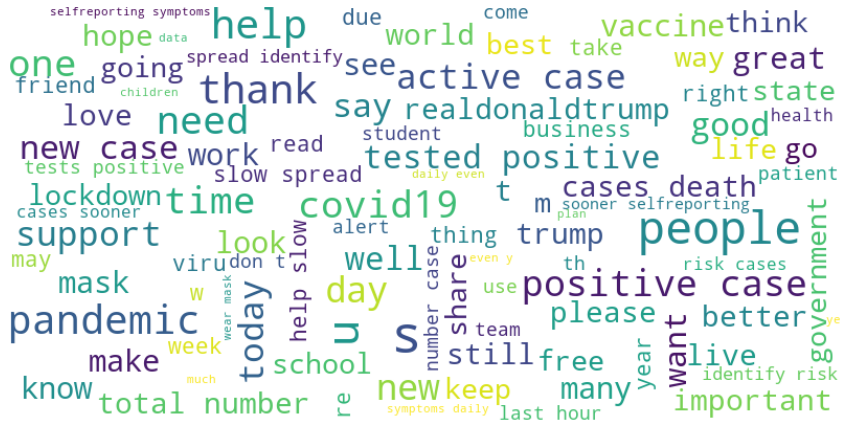

In [39]:
plt.figure(figsize=(15,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()